In [1]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ------- -------------------------------- 51.2/258.0 kB 1.3 MB/s eta 0:00:01
   ------- -------------------------------- 51.2/258.0 kB 1.3 MB/s eta 0:00:01
   ------------ -------------------------- 81.9/258.0 kB 512.0 kB/s eta 0:00:01
   ------------------ ------------------- 122.9/258.0 kB 602.4 kB/s eta 0:00:01
   ---------------------- --------------- 153.6/258.0 kB 612.6 kB/s eta 0:00:01
   ---------------------- --------------- 153.6/258.0 kB 612.6 kB/s eta 0:00:01
   ------------------------------ ------- 204.8/258.0 kB 623.6 kB/s eta 0:00:01
   ---------------------------------- --- 235.5/258.0 kB 577.6 kB/s eta 0:00:01
   -------------------------------------- 258.0/258.0 kB 566.9 kB/s eta 0:00:0

In [2]:
import os

# Define the paths
Path_data = 'G:\pj2_DatasetDR'
Healthy = os.listdir(Path_data + '/Healthy')
Mild = os.listdir(Path_data + '/Mild DR')
Moderate = os.listdir(Path_data + '/Moderate DR')
Proliferate = os.listdir(Path_data + '/Proliferate DR')
Severe = os.listdir(Path_data + '/Severe DR')

# You can now use these lists as needed in your code


In [3]:
print("classes names :", os.listdir(Path_data), "\n______________________________\n")
print("Number of classes :", len(os.listdir(Path_data)), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")


classes names : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [4]:
# Define new paths
Path_data = 'G:\pj2_DatasetDR'
Healthy = os.listdir(Path_data + '/Healthy')
Mild = os.listdir(Path_data + '/Mild DR')
Moderate = os.listdir(Path_data + '/Moderate DR')
Proliferate = os.listdir(Path_data + '/Proliferate DR')
Severe = os.listdir(Path_data + '/Severe DR')

# Create two lists to store paths of images and their labels
imgpaths = []
labels = []

# Get paths and Labels of classes and images in data 
for i in os.listdir(Path_data):
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)

# Convert two lists of imgpaths and their labels into series
Paths = pd.Series(imgpaths, name='Paths')
Labels = pd.Series(labels, name='Labels')

# Concatenate them into one DataFrame called Tr_data
Df = pd.concat([Paths, Labels], axis=1)
Df.head(5)


,Paths,Labels
0,G:\pj2_DatasetDR\Healthy\Healthy.png,Healthy
1,G:\pj2_DatasetDR\Healthy\Healthy_10.png,Healthy
2,G:\pj2_DatasetDR\Healthy\Healthy_100.png,Healthy
3,G:\pj2_DatasetDR\Healthy\Healthy_1000.png,Healthy
4,G:\pj2_DatasetDR\Healthy\Healthy_101.png,Healthy


In [5]:
#X= Df.drop(['Labels'], axis = 1)
#y = Df['Labels']
#y.value_counts()

In [6]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy= 'not majority')#string
#ros = RandomOverSampler(sampling_strategy= 1) #Numerical value

#x_ros, y_ros= ros.fit_resample(X, y)

#ax = y_ros.value_counts().plot.pie(autopct='%.2f')
#_ = ax.set_title('over-sampling')

In [7]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           805
Moderate DR       723
Mild DR           291
Proliferate DR    230
Severe DR         151
Name: count, dtype: int64

In [8]:
batch_size = 20   # As smaller, As more data generated ....In views of data size 
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


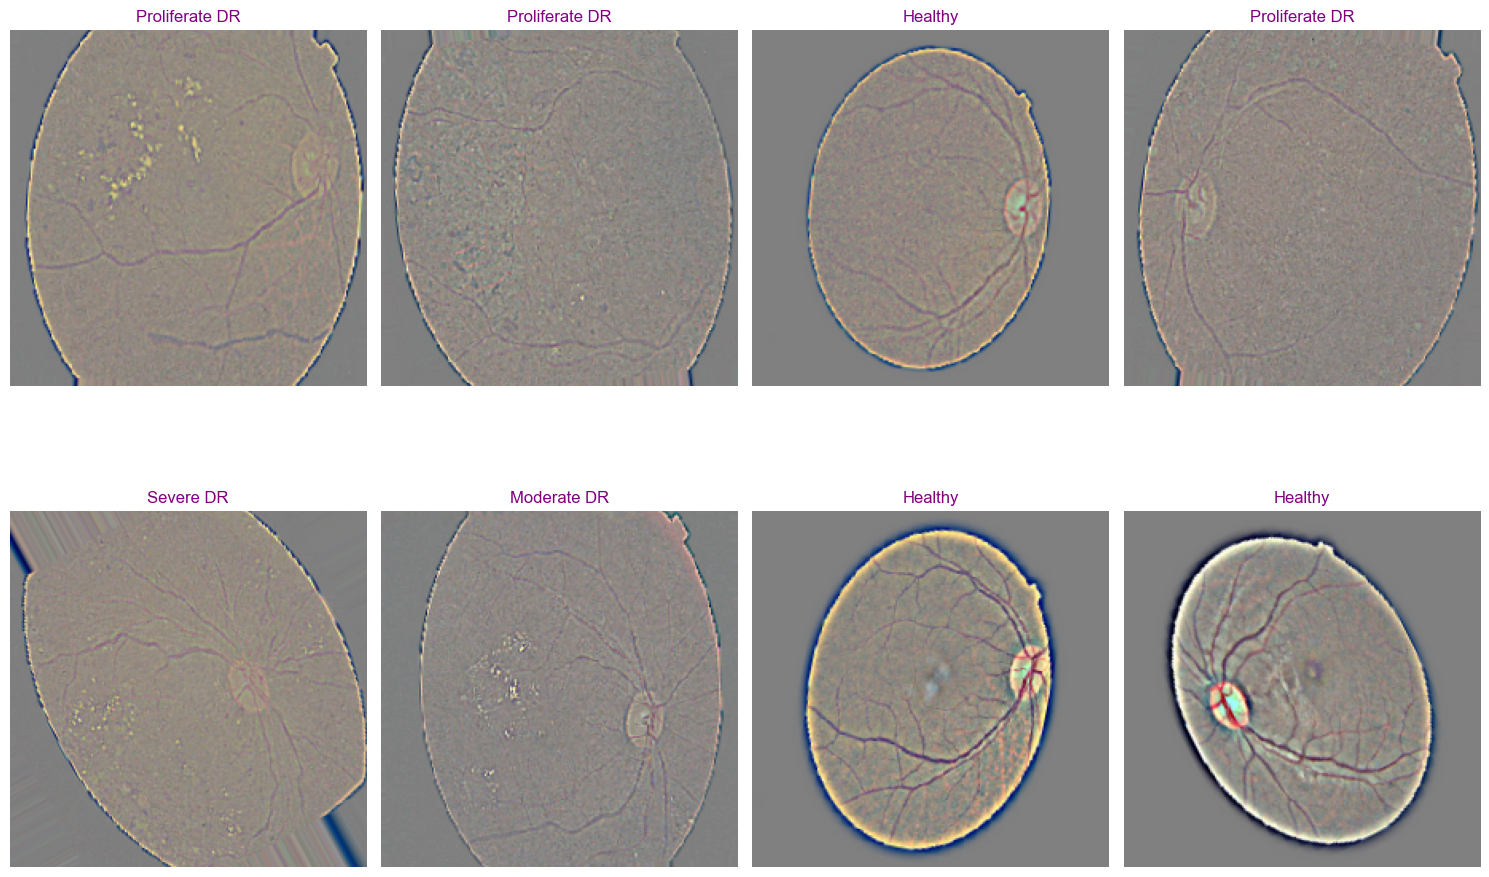

In [9]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

In [14]:
# Define number of classes 
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max') 

# Note: You are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001)(x)
x = Dense(1024, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x = Dropout(rate=0.2, seed=123)(x)
x = Dense(512, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x = Dropout(rate=0.3, seed=123)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005), activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

lr = 0.0001  # start with this learning rate


In [15]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [16]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ ?                      │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,783,535 (41.14 MB)

 Trainable params: 10,696,232 (40.80 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [18]:
epochs = 1
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1507s 11s/step - acc: 0.4113 - loss: 2.0538 - val_acc: 0.4000 - val_loss: 1.9854


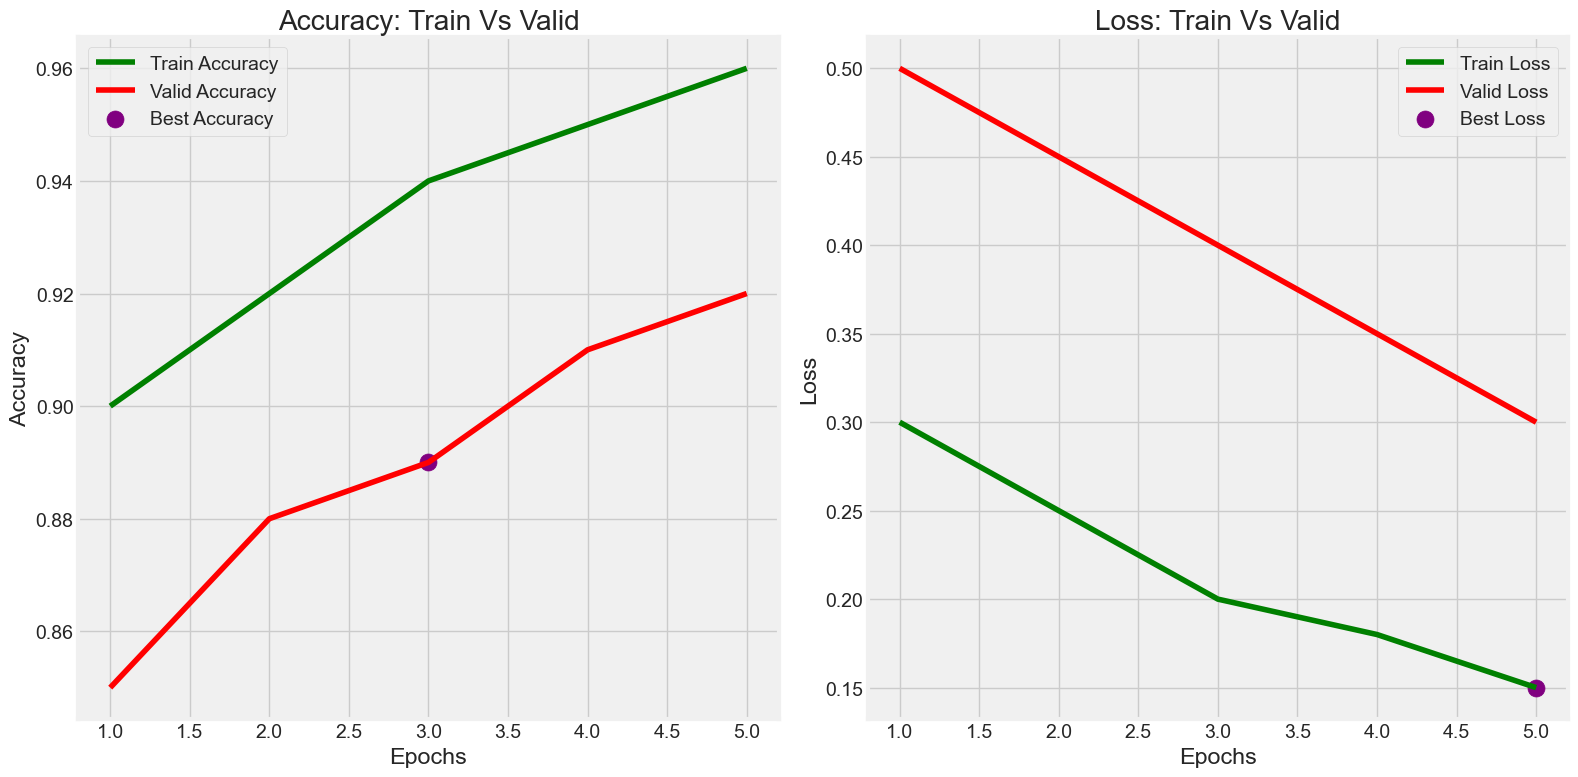

In [19]:
# Assuming you have these variables defined
import matplotlib.pyplot as plt
Epochs = [1, 2, 3, 4, 5]
tr_acc = [0.9, 0.92, 0.94, 0.95, 0.96]
v_acc = [0.85, 0.88, 0.89, 0.91, 0.92]
tr_loss = [0.3, 0.25, 0.2, 0.18, 0.15]
v_loss = [0.5, 0.45, 0.4, 0.35, 0.3]
index_acc = 2
high_Vacc = 0.89
index_loss = 4
low_Vloss = 0.15
best_acc = "Best Accuracy"
best_loss = "Best Loss"

# Plotting code
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_acc, "g", label="Train Accuracy")
plt.plot(Epochs, v_acc, "r", label="Valid Accuracy")
plt.scatter(index_acc + 1, high_Vacc, s=150, color='purple', label=best_acc)
plt.title("Accuracy: Train Vs Valid")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_loss, "g", label="Train Loss")
plt.plot(Epochs, v_loss, "r", label="Valid Loss")
plt.scatter(index_loss + 1, low_Vloss, s=150, color='purple', label=best_loss)
plt.title("Loss: Train Vs Valid")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
